# ОИАД. Лабораторная работа №3
## Король Иван, 11б группа
## Входные данные
Датасет: **insurance.csv**
Построение моделей многомерной линейной регрессии

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')


In [ ]:
data_path = 'insurance.csv'
data = pd.read_csv(data_path)
print(f'Размер набора: {data.shape[0]} наблюдений и {data.shape[1]} признаков')
data.head()


Размер набора: 1338 наблюдений и 7 признаков


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.1. Проверка данных на пропуски и выбросы


In [38]:
print(f'\nХарактеристики признаков:')
display(data.describe())

print('\nКоличество пропусков по столбцам:')
print(data.isna().sum())



Характеристики признаков:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



Количество пропусков по столбцам:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [33]:
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

print('Количество выбросов (IQR) по слобцам числовых признаков:')
for col in ['age','bmi','children','charges']:
    outs = iqr_outliers(data[col])
    print(f"{col} -- {len(outs)}")

Количество выбросов (IQR) по слобцам числовых признаков:
age -- 0
bmi -- 9
children -- 0
charges -- 139


## 1.2. Приведение категориальных признаков к числовым


In [39]:
df = data.copy()

df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

df = pd.get_dummies(df, columns=['region'], drop_first=True)

print('Проверка на пропуски после приведения:')
print(df.isna().sum())
df.head()


Проверка на пропуски после приведения:
age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


## 1.3. Рассчет парных корреляций признаков


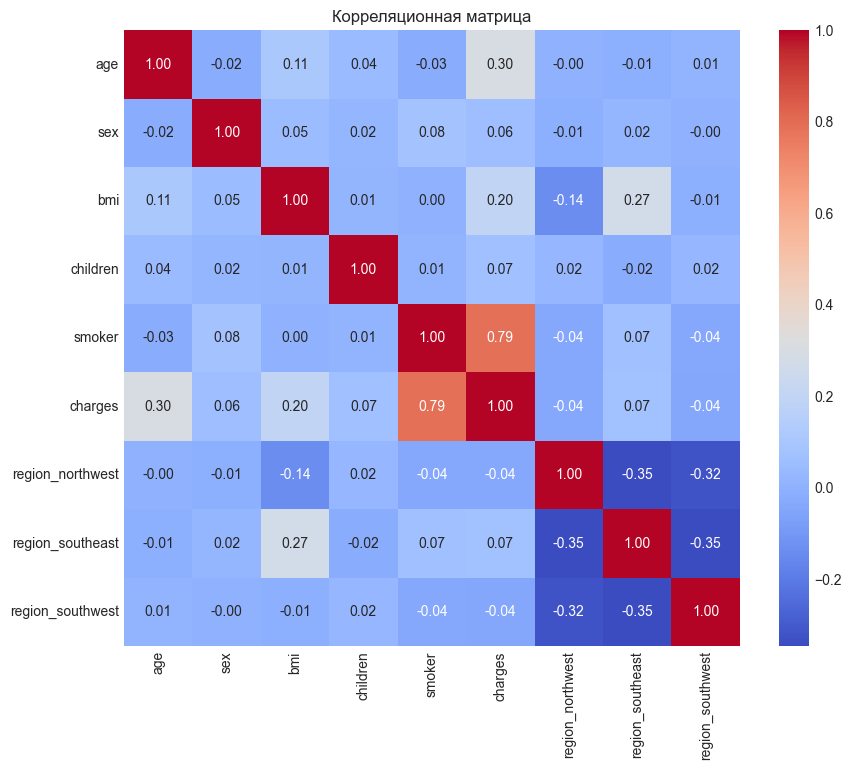

Корреляции признаков с целевой переменной charges:
charges             1.000000
smoker              0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex                 0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64


In [35]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

print('Корреляции признаков с целевой переменной charges:')
print(corr_matrix['charges'].sort_values(ascending=False))


# 2. Построение модели линейной регрессии
## 2.1. Построение модели аналитически
### - Подготовка матрицы признаков и вектора целевой переменной

In [7]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['charges']).values
y = df['charges'].values.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])



print('Размерность X:', X_scaled.shape)
print('Размерность y:', y.shape)


Размерность X: (1338, 9)
Размерность y: (1338, 1)


In [52]:
def add_bias_column(X: np.ndarray) -> np.ndarray:
    return np.hstack([np.ones((X_scaled.shape[0], 1)), X])


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot


## Модель 1 - аналитическое решение


In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def analytic_solution(X, y):
    XtX = X.T @ X
    Xty = X.T @ y
    theta = np.linalg.pinv(XtX) @ Xty
    return theta


theta_normal = analytic_solution(X_train, y_train)
print('Веса без регуляризации:')
print(theta_normal)
pred_normal = X_test @ theta_normal


print("\nОценка без регуляризации:")
print(f"MSE: {mse(y_test, pred_normal):.2f}")
print(f"R2 score: {r2_score(y_test, pred_normal):.4f}")



Веса без регуляризации:
[[ 1.33143359e+04]
 [ 3.60914902e+03]
 [-9.29533694e+00]
 [ 2.05488506e+03]
 [ 5.12478869e+02]
 [ 9.54425109e+03]
 [-1.58959435e+02]
 [-2.92759080e+02]
 [-3.47270359e+02]]

Оценка без регуляризации:
MSE: 33596915.85
R2 score: 0.7836


## 2.2. Градиентный спуск

In [68]:
class GradientDescentRegressor:
    def __init__(self, learning_rate=0.01, max_iter=20000, tolerance=1e-6, verbose=False, log_every=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.log_every = log_every
        self.theta_ = None
        self.loss_history_ = []
        self.n_iter_ = 0

    def fit(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        n_samples, n_features = X.shape
        self.theta_ = np.zeros((n_features, 1))
        self.loss_history_ = []

        for iteration in range(self.max_iter):
            predictions = X @ self.theta_
            errors = predictions - y
            gradient = (1 / n_samples) * (X.T @ errors)
            loss = mse(y, predictions)
            self.loss_history_.append(loss)

            step = self.learning_rate * gradient
            self.theta_ -= step

            grad_norm = np.linalg.norm(gradient)
            step_norm = np.linalg.norm(step)

            if self.verbose and iteration % self.log_every == 0:
                print(f"Iter {iteration:5d} | loss={loss:.4f} | ||grad||={grad_norm:.6f}")

            if grad_norm < self.tolerance or step_norm < self.tolerance:
                break

        self.n_iter_ = iteration + 1
        return self

    def predict(self, X):
        if self.theta_ is None:
            raise RuntimeError('Model is not fitted yet')
        return X @ self.theta_

In [69]:
gd_model = GradientDescentRegressor(
    learning_rate=0.05,
    max_iter=50000,
    tolerance=1e-8,
    verbose=True,
    log_every=500,
)

gd_model.fit(X_train, y_train)
print(f"Обучение завершено за {gd_model.n_iter_} итераций")
print('Полученные веса:')
print(gd_model.theta_)

Iter     0 | loss=322451733.1842 | ||grad||=16916.612537
Iter   500 | loss=37277681.7112 | ||grad||=0.053993
Iter  1000 | loss=37277681.7020 | ||grad||=0.000018
Обучение завершено за 1280 итераций
Полученные веса:
[[ 1.33143359e+04]
 [ 3.60914902e+03]
 [-9.29533694e+00]
 [ 2.05488506e+03]
 [ 5.12478869e+02]
 [ 9.54425109e+03]
 [-1.58959435e+02]
 [-2.92759080e+02]
 [-3.47270359e+02]]


MSE: 33596915.85
R^2: 0.7836


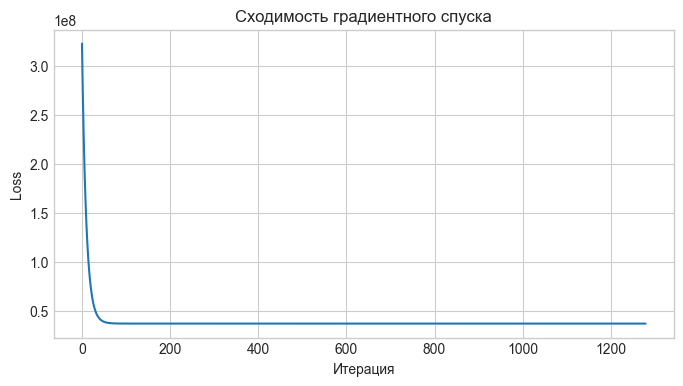

In [70]:
pred_gd = gd_model.predict(X_test)
print(f"MSE: {mse(y_test, pred_gd):.2f}")
print(f"R^2: {r2_score(y_test, pred_gd):.4f}")

plt.figure(figsize=(8, 4))
plt.plot(gd_model.loss_history_)
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.title('Сходимость градиентного спуска')
plt.show()

# 3. Добавление L2-регуляризации
## 3.1. Построение модели аналитически

In [71]:
def analytic_solution_l2(X, y, alpha: float):
    n_features = X.shape[1]
    I = np.eye(n_features)
    XtX = X.T @ X
    Xty = X.T @ y
    theta = np.linalg.inv(XtX + alpha * I) @ Xty
    return theta

alpha_example = 1.0
theta_ridge = analytic_solution_l2(X_train, y_train, alpha_example)


pred_ridge = X_test @ theta_ridge

print(f"\nВеса с L2-регуляризацией, alpha={alpha_example}:")
print(theta_ridge)

print("\nОценка с L2-регуляризацией,")
print(f"MSE: {mse(y_test, pred_ridge):.2f}")
print(f"R^2 score: {r2_score(y_test, pred_ridge):.4f}")


Веса с L2-регуляризацией, alpha=1.0:
[[ 1.33019310e+04]
 [ 3.60570175e+03]
 [-8.44534712e+00]
 [ 2.05276518e+03]
 [ 5.12473463e+02]
 [ 9.53510942e+03]
 [-1.58685844e+02]
 [-2.91376404e+02]
 [-3.46482410e+02]]

Оценка с L2-регуляризацией,
MSE: 33599406.53
R^2 score: 0.7836


## 3.2. Градиентный спуск с L2-регуляризацией

In [72]:
class GradientDescentRegressorL2:
    def __init__(
        self,
        learning_rate=0.01,
        alpha=0.1,
        max_iter=20000,
        tolerance=1e-6,
        verbose=False,
        log_every=1000,
    ):
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.log_every = log_every
        self.theta_ = None
        self.loss_history_ = []
        self.n_iter_ = 0

    def fit(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        n_samples, n_features = X.shape
        self.theta_ = np.zeros((n_features, 1))
        self.loss_history_ = []

        for iteration in range(self.max_iter):
            predictions = X @ self.theta_
            errors = predictions - y

            gradient_data = (2 / n_samples) * (X.T @ errors)
            theta_reg = self.theta_.copy()
            theta_reg[0] = 0
            gradient_reg = 2 * self.alpha * theta_reg / n_features
            gradient = gradient_data + gradient_reg

            loss_data = mse(y, predictions)
            loss_reg = self.alpha * np.sum(theta_reg ** 2)
            total_loss = loss_data + loss_reg
            self.loss_history_.append(total_loss)

            step = self.learning_rate * gradient
            self.theta_ -= step

            grad_norm = np.linalg.norm(gradient)
            step_norm = np.linalg.norm(step)

            if self.verbose and iteration % self.log_every == 0:
                print(
                    f"Iter {iteration:5d} | loss={total_loss:.4f} | "
                    f"||grad||={grad_norm:.6f}"
                )

            if grad_norm < self.tolerance or step_norm < self.tolerance:
                break

        self.n_iter_ = iteration + 1
        return self

    def predict(self, X):
        if self.theta_ is None:
            raise RuntimeError('Model is not fitted yet')
        return X @ self.theta_


In [73]:
gd_l2_model = GradientDescentRegressorL2(
    learning_rate=0.05,
    alpha=0.1,
    max_iter=50000,
    tolerance=1e-8,
    verbose=True,
    log_every=500,
)

gd_l2_model.fit(X_train, y_train)
print(f"Обучение (L2) завершено за {gd_l2_model.n_iter_} итераций")
print('Полученные веса с L2-регуляризацией:')
print(gd_l2_model.theta_)


Iter     0 | loss=322451733.1842 | ||grad||=33833.225074
Iter   500 | loss=47928516.2363 | ||grad||=0.000017
Обучение (L2) завершено за 634 итераций
Полученные веса с L2-регуляризацией:
[[ 1.33148191e+04]
 [ 3.56682615e+03]
 [-1.42151609e+00]
 [ 2.03230340e+03]
 [ 5.11015245e+02]
 [ 9.43643340e+03]
 [-1.53127778e+02]
 [-2.73763284e+02]
 [-3.37623325e+02]]


MSE: 33704440.70
R^2: 0.7829


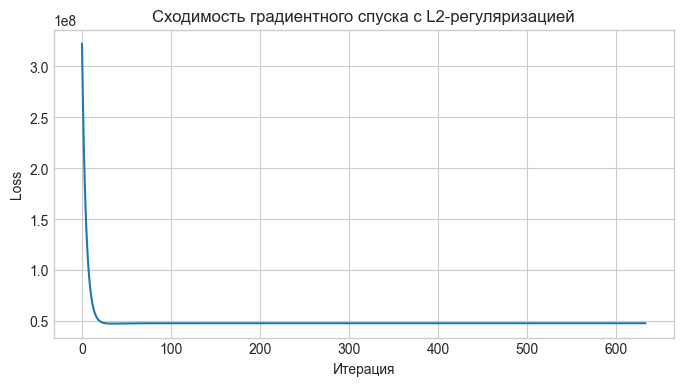

In [74]:
pred_gd_l2 = gd_l2_model.predict(X_test)
print(f"MSE: {mse(y_test, pred_gd_l2):.2f}")
print(f"R^2: {r2_score(y_test, pred_gd_l2):.4f}")

plt.figure(figsize=(8, 4))
plt.plot(gd_l2_model.loss_history_)
plt.xlabel('Итерация')
plt.ylabel('Loss')
plt.title('Сходимость градиентного спуска с L2-регуляризацией')
plt.show()


# 4. Сравнение моделей на тестовых данных (X_test)


MSE (прогноз среднего значения): 155391443.68
MSE (модель без регуляризации): 33596915.85
MSE (модель градиентного спуска): 33596915.85
MSE (модель с L2-регуляризацией): 33599406.53
MSE (модель градиентного спуска с L2-регуляризацией): 33704440.7


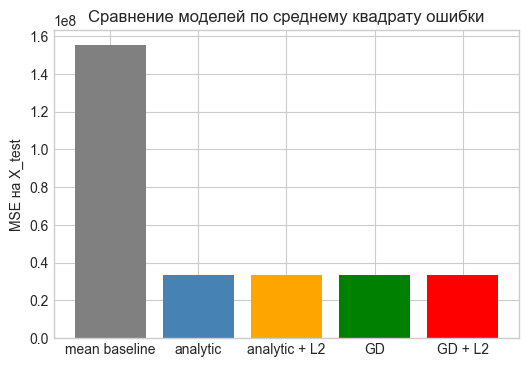

In [75]:
mean_train = y_train.mean()
y_pred_mean = np.full_like(y_test, fill_value=mean_train)

mse_mean = mse(y_test, y_pred_mean)
mse_no_reg = mse(y_test, pred_normal)
mse_gd = mse(y_test, pred_gd)
mse_gd_l2 = mse(y_test, pred_gd_l2)
mse_l2 = mse(y_test, pred_ridge)

print('MSE (прогноз среднего значения):', round(mse_mean, 2))
print('MSE (модель без регуляризации):', round(mse_no_reg, 2))
print('MSE (модель градиентного спуска):', round(mse_gd, 2))
print('MSE (модель с L2-регуляризацией):', round(mse_l2, 2))
print('MSE (модель градиентного спуска с L2-регуляризацией):', round(mse_gd_l2, 2))

labels = ['mean baseline', 'analytic', 'analytic + L2', 'GD', 'GD + L2']
values = [mse_mean, mse_no_reg, mse_l2, mse_gd, mse_gd_l2]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['gray', 'steelblue', 'orange', 'green', 'red'])
plt.ylabel('MSE на X_test')
plt.title('Сравнение моделей по среднему квадрату ошибки')
plt.show()
